# Đánh giá mô hình

BTVN:

Đánh giá mô hình huấn luyện trên tập dữ liệu *churn_modeling.csv* dự đoán khách hàng rời bỏ dịch vụ.

Chia tập dữ liệu train/test với *test_size = 0.2* và *random_state = 42*

Sử dụng 3 mô hình để huấn luyện và dự đoán.
- Mô hinh 1: luôn luôn dự đoán là 0
- Mô hình 2: Logistic regression
- Mô hình 3: KNN.

Các thông số tính toán:
- Accuracy.
- Confusion matrix.
- Precision, recall, f1.
- AUC, ROC (nếu có).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [4]:
df = df.drop(['RowNumber','CustomerId','Surname'], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


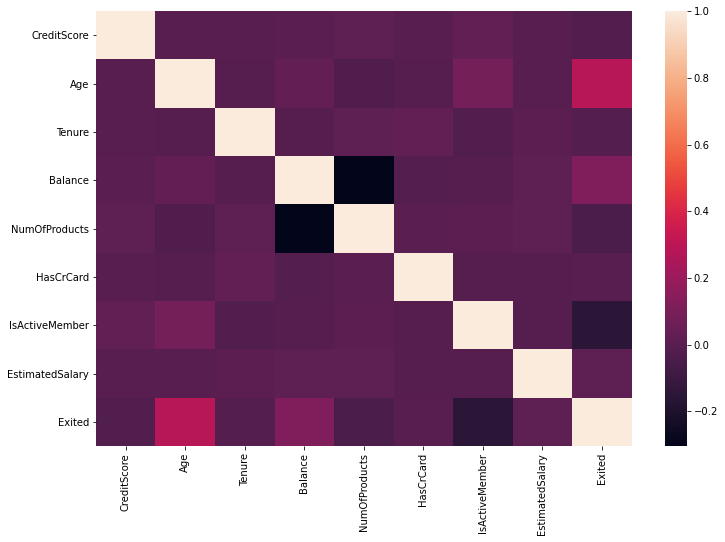

In [5]:
corr_mat = df.corr()
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax = sns.heatmap(corr_mat, ax=ax)

In [6]:
corr_above6 = pd.DataFrame(corr_mat['Exited'])
corr_above6.columns = ['Exited']
corr_above6

,Exited
CreditScore,-0.027094
Age,0.285323
Tenure,-0.014001
Balance,0.118533
NumOfProducts,-0.047820
HasCrCard,-0.007138
IsActiveMember,-0.156128
EstimatedSalary,0.012097
Exited,1.000000


### 1hot-encode and split data for training

In [7]:
df_1hot = pd.get_dummies(df)
print(df.shape, df_1hot.shape)

(10000, 11) (10000, 14)


In [8]:
y = df_1hot['Exited'].to_numpy()
X = df_1hot.drop(['Exited'], axis=1).to_numpy()

In [9]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Mô hình 1: LogisticRegression 

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
LogR_1 = LogisticRegression()
LogR_1.fit(X_train, y_train)
LogR_1.score(X_train, y_train)

0.787625

In [12]:
LogR_1.score(X_test, y_test)

0.8005

In [13]:
y_pred = LogR_1.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1607
           1       0.45      0.07      0.12       393

    accuracy                           0.80      2000
   macro avg       0.63      0.53      0.51      2000
weighted avg       0.74      0.80      0.74      2000



=> Mô hình thiên về dự đoán 0 cho Exited

In [15]:
print(confusion_matrix(y_test, y_pred))

[[1573   34]
 [ 365   28]]


In [16]:
cm2 = confusion_matrix(y_test, y_pred)

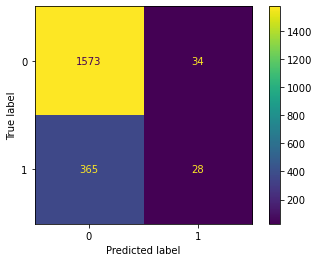

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

=> Số người exited với dịch vụ là 393 nhưng chỉ có 28 người được dự đoán đúng (True positive) còn 365 người dự đoán sai (false positive)

In [18]:
y_prob = LogR_1.predict_proba(X_test)

In [19]:
y_prob[:,1]

array([0.21588858, 0.1905133 , 0.23690294, ..., 0.16087812, 0.09062292,
       0.23734934])

In [20]:
from sklearn.metrics import roc_curve, auc

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

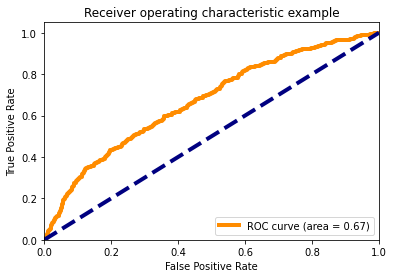

In [22]:
plt.figure()
lw = 4
plt.plot(
    fpr,
    tpr,
    lw=lw,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### Thử set class_weight = 'balanced' cho dữ liệu mất cân bằng

In [23]:
LogR_2 = LogisticRegression(class_weight = 'balanced')
LogR_2.fit(X_train, y_train)
LogR_2.score(X_train, y_train)

0.6625

In [24]:
LogR_2.score(X_test, y_test)

0.639

In [25]:
y_pred2 = LogR_2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.64      0.74      1607
           1       0.30      0.65      0.41       393

    accuracy                           0.64      2000
   macro avg       0.59      0.64      0.58      2000
weighted avg       0.77      0.64      0.68      2000



=> Recall của 2 label 0 và 1 gần bằng nhau, tuy nhiên độ chính xác khi phát hiện đúng label 1 vẫn thấp hơn nhiều so với label 0

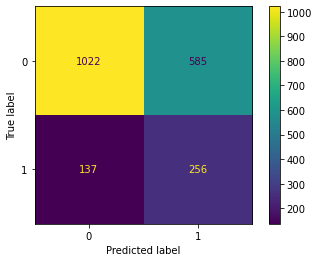

In [26]:
cm2 = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()

=> Mô hình phát hiện exited là 1 cao hơn so với model 1 tuy nhiên phát hiện exited là 0 đúng cũng bị giảm đi nhiều

In [27]:
y_prob2 = LogR_2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob2[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

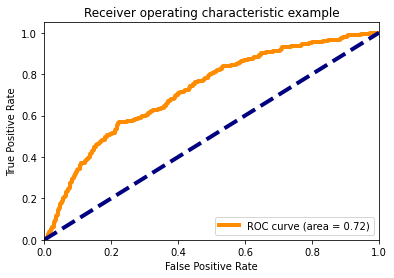

In [28]:
plt.figure()
lw = 4
plt.plot(
    fpr,
    tpr,
    lw=lw,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

=> Hiệu suất model lần này tăng lên khoảng 72%, tuy nhiên accuracy thì giảm còn 64% 

# 2. Mô hình 2: kNN - luôn dự đoán nhãn 0

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
# Chọn tham số k gần với square root of N
np.sqrt(len(X_train))

89.44271909999159

In [31]:
k = 89

In [32]:
knn = KNeighborsClassifier(n_neighbors=k)

In [33]:
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

0.7945

In [34]:
knn.score(X_test, y_test)

0.8035

In [35]:
y_predict_kNN = knn.predict(X_test)
print(classification_report(y_test, y_predict_kNN, zero_division=0))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1607
           1       0.00      0.00      0.00       393

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.45      2000
weighted avg       0.65      0.80      0.72      2000



=> Accuracy 80% nhưng chỉ nhận diện toàn bộ test data output ra nhãn 0 

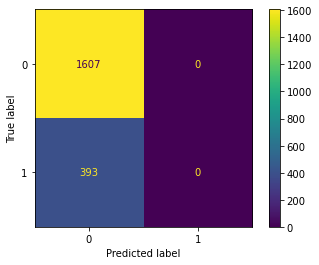

In [36]:
cm_knn = confusion_matrix(y_test, y_predict_kNN)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp.plot()

=> Vì output của test data là label 0 nên false negative và true positive đều bằng 0

In [37]:
y_prob_kNN = knn.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_kNN[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

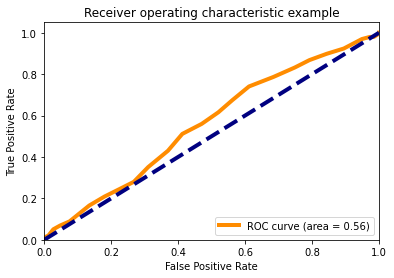

In [38]:
plt.figure()
lw = 4
plt.plot(
    fpr,
    tpr,
    lw=lw,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

=> Mô hình không hợp lý

# 3. Thử oversampling tạo thêm dữ liệu cho label 1 nhờ SMOTE của sklearn (kNN algorithm) + kNN cho phân loại dữ liệu

In [76]:
from imblearn.over_sampling import SMOTE

In [77]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 1644
Before OverSampling, counts of label '0': 6356 

After OverSampling, the shape of train_X: (12712, 13)
After OverSampling, the shape of train_y: (12712,) 

After OverSampling, counts of label '1': 6356
After OverSampling, counts of label '0': 6356


In [109]:
knn_S = KNeighborsClassifier(n_neighbors=k)

In [110]:
k//6

14

In [111]:
knn_S.fit(X_train_res, y_train_res)
knn_S.score(X_train_res, y_train_res)

0.5971522970421649

In [112]:
y_predict_knnS = knn_S.predict(X_test)
print(classification_report(y_test, y_predict_knnS, zero_division=0))

              precision    recall  f1-score   support

           0       0.83      0.54      0.65      1607
           1       0.22      0.54      0.31       393

    accuracy                           0.54      2000
   macro avg       0.52      0.54      0.48      2000
weighted avg       0.71      0.54      0.59      2000



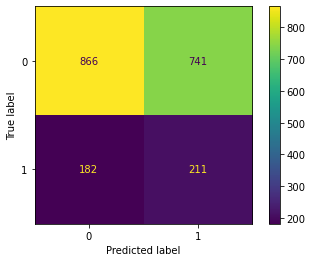

In [113]:
cm_knnS = confusion_matrix(y_test, y_predict_knnS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knnS)
disp.plot()

=> Kết quả từ mô hình như random

In [114]:
y_prob_knnS = knn_S.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knnS[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

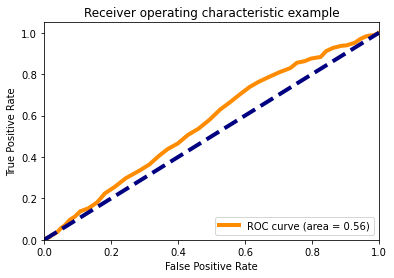

In [115]:
plt.figure()
lw = 4
plt.plot(
    fpr,
    tpr,
    lw=lw,
    color="darkorange",
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

=> Mô hình không hiệu quả: Acurracy và AUC khoảng 0.50